In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot
import datetime
import psycopg2

In [2]:
START_DATE = datetime.date(2019, 10, 1)
END_DATE = datetime.datetime.utcnow().date()
START_DATE, END_DATE, END_DATE-START_DATE

(datetime.date(2019, 10, 1),
 datetime.date(2020, 6, 23),
 datetime.timedelta(days=266))

In [5]:
from fl_settings import user, password, server, port, db
DBPATH = 'postgresql://{0}:{1}@{2}:{3}/{4}?application_name=notebook'.format(
    user, password, server, port, db)
engine = create_engine(DBPATH)

In [11]:
sql_account_level = 'select account_level, count(*) from client group by account_level;'
df_account_level = pd.read_sql_query(sql_account_level, con=engine)
df_account_level

,account_level,count
0,UPRID,7
1,ANONYMOUS,103


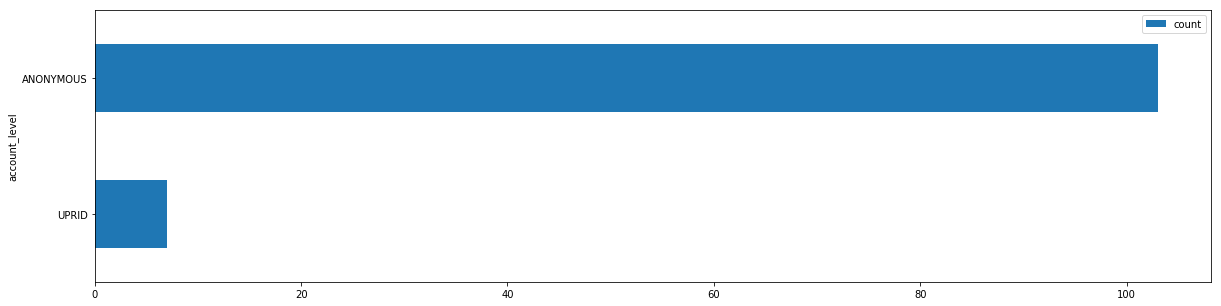

In [67]:
df_account_level.plot.barh(x='account_level', y='count', rot=0, figsize=(20,5))

In [26]:
sql_tx = """
select 
(cs.data->>'operType')::bigint as type,
(cs.data->>'amount')::float as sum_amount,
(cs.data->>'debet')::bool as debet,
(data->>'docDate')::timestamp,
*
from card_statement cs 
left join card c on cs.card_id = c.id
left join account a on a.id = c.account_id
left join client cl on cl.id = a.client_id
left join bank b on b.id = cl.bank_id;
"""
with engine.connect() as conn:
    df_tx = pd.read_sql_query(sql_tx, con=conn).sort_values(by='timestamp')

# сделать колонки уникальными    
cols=pd.Series(df_tx.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
df_tx.columns=cols

# поле даты
df_tx['tx_date'] = df_tx.timestamp.dt.date
# изменение суммы на карте
df_tx['tx_amount'] = df_tx.apply(lambda x: x['sum_amount'] if x['debet']==False else -x['sum_amount'], axis=1)
# баланс по всем картам сразу
df_tx['tx_cumsum']=df_tx['tx_amount'].cumsum()

print('размер датасета:{}'.format(df_tx.shape))

размер датасета:(13, 65)


In [27]:
df_tx[['type', 'sum_amount', 'debet', 'timestamp', 'card_id', 'statement_balance', 
       'tx_date', 'tx_amount', 'tx_cumsum']]

,type,sum_amount,debet,timestamp,card_id,statement_balance,tx_date,tx_amount,tx_cumsum
6,2,100.0,False,2020-04-27 21:24:47,3034,100.0,2020-04-27,100.0,100.0
7,2,100.0,False,2020-04-28 10:25:51,3034,200.0,2020-04-28,100.0,200.0
8,1,55.0,True,2020-04-29 01:06:00,3034,145.0,2020-04-29,-55.0,145.0
9,2,100.0,False,2020-04-29 14:53:25,3034,245.0,2020-04-29,100.0,245.0
10,1,45.0,True,2020-04-30 01:05:48,3034,200.0,2020-04-30,-45.0,200.0
4,7,35.0,True,2020-05-01 14:25:02,3034,165.0,2020-05-01,-35.0,165.0
11,1,25.0,True,2020-05-01 14:25:03,3034,140.0,2020-05-01,-25.0,140.0
12,2,50.0,False,2020-05-04 14:47:43,3034,190.0,2020-05-04,50.0,190.0
5,1,55.0,True,2020-05-06 01:05:09,3034,135.0,2020-05-06,-55.0,135.0
0,2,12.0,False,2020-05-06 21:23:35,3034,147.0,2020-05-06,12.0,147.0


1 - покупка по карте

7 - перевод на другую карту

2,3,4 - пополнения по карте(перевод с банкомата, перевод с другой карты и что-то еще)

5 - снятие денег через банкомат

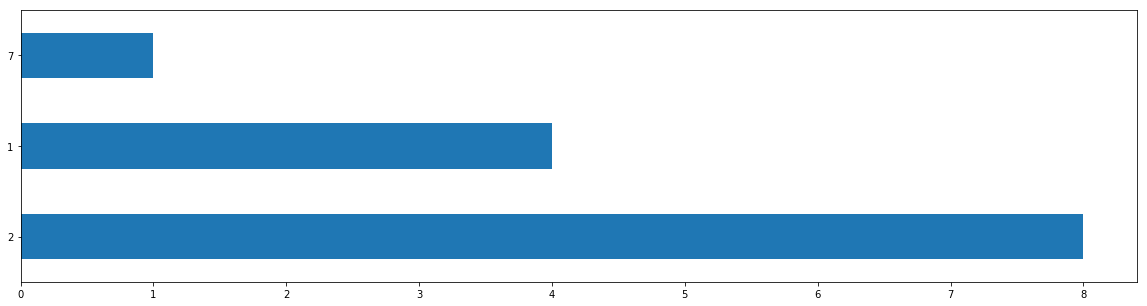

In [23]:
df_tx.type.value_counts().plot.barh(rot=0, figsize=(20,5))

In [24]:
sum_tx_buy = df_tx[df_tx.type==1].sum_amount.sum()
sum_tx_card2card = df_tx[df_tx.type==7].sum_amount.sum()
print('Сумма покупок по картам: {}'.format(sum_tx_buy))
print('Сумма переводов с карт на др. карты: {}'.format(sum_tx_card2card))
df_tx_in = df_tx[df_tx.type.isin([2,3,4])]
sum_tx_in = df_tx_in.sum_amount.sum()
count_tx_in = df_tx_in.shape[0]
avg_tx_in = df_tx_in.sum_amount.mean()
print('Сумма пополнений по картам: {}'.format(sum_tx_in))
print('Количество пополнений по картам: {}'.format(count_tx_in))
print('Средняя сумма пополнения: {}'.format(avg_tx_in))

Сумма покупок по картам: 180.0
Сумма переводов с карт на др. карты: 35.0
Сумма пополнений по картам: 389.0
Количество пополнений по картам: 8
Средняя сумма пополнения: 48.625


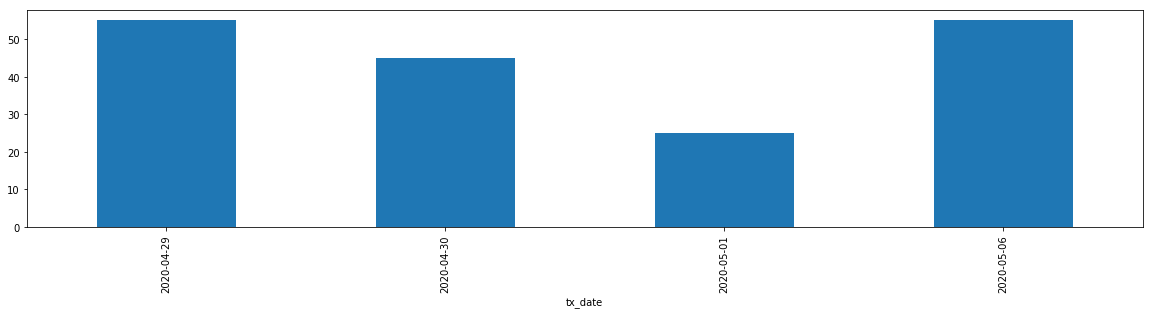

In [64]:
# для графиков по датам
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

# покупки по картам
df_tx_buy = df_tx[df_tx.type==1].groupby('tx_date')['sum_amount'].sum()
df_tx_buy.plot(figsize=(20,4), kind='bar')

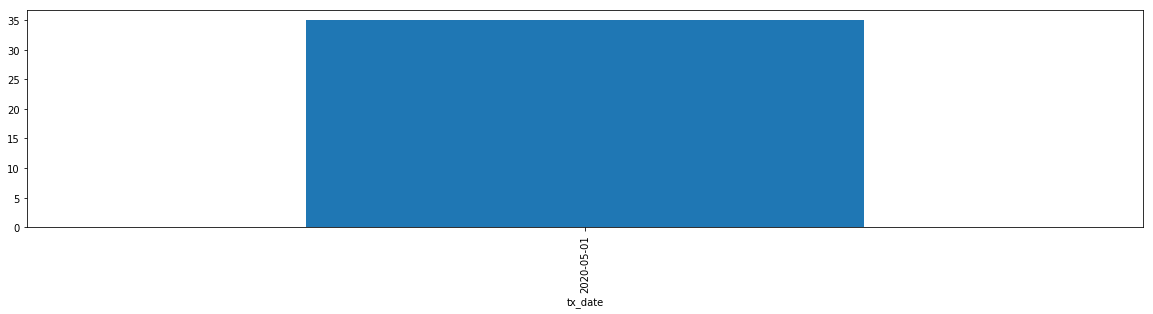

In [61]:
# переводы с карты на карту
df_tx_card2card = df_tx[df_tx.type==7].groupby('tx_date')['sum_amount'].sum()
df_tx_card2card.plot(figsize=(20,4), kind='bar')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3A2FE89B0>,
      dtype=object)

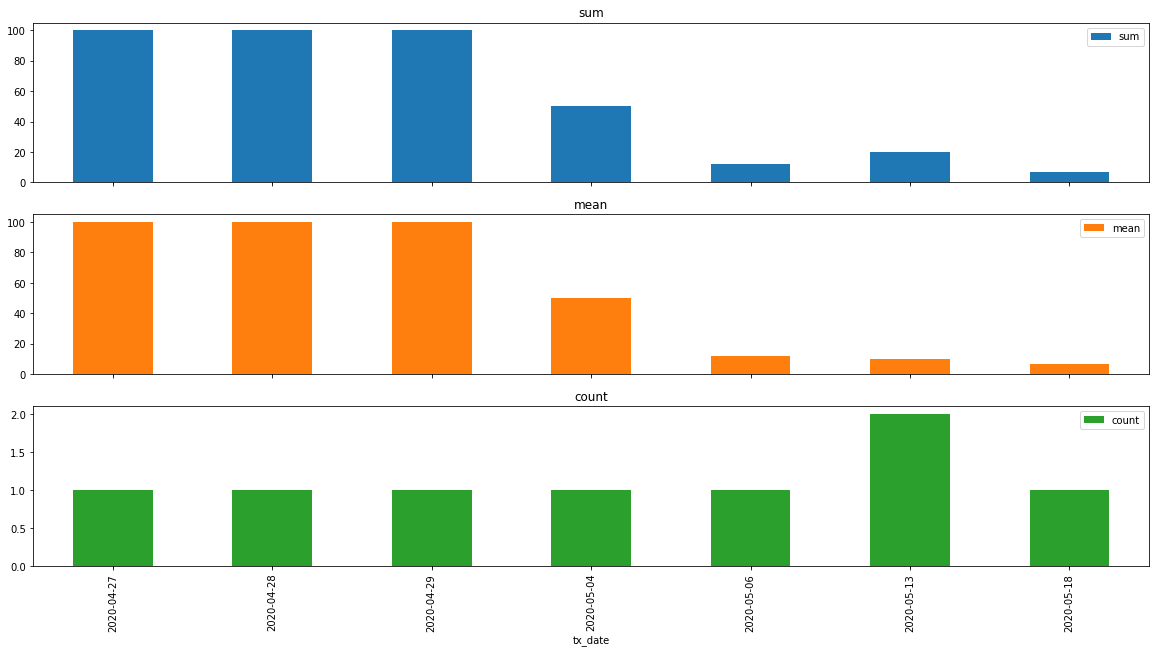

In [65]:
# пополнения
df_group = df_tx[df_tx.type.isin([2,3,4])].groupby('tx_date')['sum_amount'].agg(['sum', 'mean', 'count'])
df_group.plot(subplots=True, figsize=(20,10), kind='bar', stacked=False) #bar, area, line

In [29]:
DATE = datetime.datetime(2020, 6, 23)
date_balance = df_tx[df_tx['timestamp']<=DATE+datetime.timedelta(days=1)]['tx_cumsum'].iloc[-1]
date_cards = df_tx[(df_tx.type.isin([2,3,4])) & 
                   (df_tx['timestamp']<=DATE+datetime.timedelta(days=1))].card_id.nunique()
print('Суммарный баланс по картам на дату просмотра: {}'.format(date_balance))
print('Количество пополненных карт на дату просмотра: {}'.format(date_cards))

Суммарный баланс по картам на дату просмотра: 174.0
Количество пополненных карт на дату просмотра: 1
